In [24]:
import numpy as np
import time
import utils
import matplotlib.pyplot as plt
%matplotlib inline
import torch
import model
import torch.optim as optim

In [25]:
batch_size = 32
output_folder = r"/media/adam/HDD_2/Datasets/NURBS_Geometry/IJAC/outputs_pointcloud" # folder path to save the results
save_results = False # save the results to output_folder
use_GPU = True # use GPU, False to use CPU
latent_size = 128 # bottleneck size of the Autoencoder model

epochs = 100
show_plots_during_training = False

In [26]:
def visualize_pointcloud(pointcloud, color='b'):
 
    #check if pointcloud in pytorch tensor
    if isinstance(pointcloud, torch.Tensor):
        pointcloud = pointcloud.cpu().detach().numpy()
    
    #check if pointcloud in numpy array
    if isinstance(pointcloud, np.ndarray):
        pointcloud = pointcloud
    else:
        raise ValueError("pointcloud type not supported; must be numpy array or pytorch tensor")
    
    assert len(pointcloud.shape) == 2, "must be 2D array"

    if pointcloud.shape[0] != 3:
        pointcloud = pointcloud.T
    
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter(pointcloud[0, :], pointcloud[1, :], pointcloud[2, :], c=color, marker='o')
    ax.set_xlabel('X Axis')
    ax.set_ylabel('Y Yxis')
    ax.set_zlabel('Z Zxis')
    plt.show()

In [ ]:
from Dataloaders import GetDataLoaders

#pc_array = np.load("data/chair_set.npy")
pc_array = np.load("/media/adam/HDD_2/Datasets/NURBS_Geometry/IJAC/poly_surface_v1/combined_array.npy")
print(pc_array.shape)

# load dataset from numpy array and divide 90%-10% randomly for train and test sets
train_loader, test_loader = GetDataLoaders(npArray=pc_array, batch_size=batch_size)

# Assuming all models have the same size, get the point size from the first model
point_size = len(train_loader.dataset[0])
print(point_size)

In [ ]:
# visualize a random pointcloud
# get a random pointcloud from the dataset

random_pointcloud = train_loader.dataset[0]
print(random_pointcloud.shape)
visualize_pointcloud(train_loader.dataset[0])

In [29]:
net = model.PointCloudAE(point_size,latent_size)

if(use_GPU):
    device = torch.device("cuda:0")
    if torch.cuda.device_count() > 1: # if there are multiple GPUs use all
        net = torch.nn.DataParallel(net)
else:
    device = torch.device("cpu")

net = net.to(device)

In [30]:
from pytorch3d.loss import chamfer_distance # chamfer distance for calculating point cloud distance

optimizer = optim.Adam(net.parameters(), lr=0.0005)

In [31]:
def train_epoch():
    epoch_loss = 0
    for i, data in enumerate(train_loader):
        optimizer.zero_grad()
        
        data = data.to(device)
        output = net(data.permute(0,2,1)) # transpose data for NumberxChannelxSize format
        loss, _ = chamfer_distance(data, output) 
        loss.backward()
        optimizer.step()
        
        epoch_loss += loss.item()
        
    return epoch_loss/i

In [32]:
def test_batch(data): # test with a batch of inputs
    with torch.no_grad():
        data = data.to(device)
        output = net(data.permute(0,2,1))
        loss, _ = chamfer_distance(data, output)
        
    return loss.item(), output.cpu()

In [33]:
def test_epoch(): # test with all test set
    with torch.no_grad():
        epoch_loss = 0
        for i, data in enumerate(test_loader):
            loss, output = test_batch(data)
            epoch_loss += loss

    return epoch_loss/i

In [34]:
if(save_results):
    utils.clear_folder(output_folder)

epoch 85 train loss : 0.007559482264332474 test loss : 0.00832101951042811 epoch time : 0.27735376358032227

epoch 86 train loss : 0.007467102538794279 test loss : 0.008469159994274379 epoch time : 0.2740960121154785

epoch 87 train loss : 0.007447248664019363 test loss : 0.008449724192420642 epoch time : 0.2722177505493164

epoch 88 train loss : 0.007451782811300031 test loss : 0.008310722000896931 epoch time : 0.27596211433410645

epoch 89 train loss : 0.007428782719320484 test loss : 0.00836089647685488 epoch time : 0.27632880210876465

epoch 90 train loss : 0.007470860624951976 test loss : 0.008305905976643164 epoch time : 0.27062439918518066

epoch 91 train loss : 0.007478493521921337 test loss : 0.0083281888316075 epoch time : 0.2750244140625

epoch 92 train loss : 0.0074565547086032375 test loss : 0.008507616259157658 epoch time : 0.2742626667022705

epoch 93 train loss : 0.007442316861956247 test loss : 0.008299179778744777 epoch time : 0.3197319507598877

epoch 94 train loss :

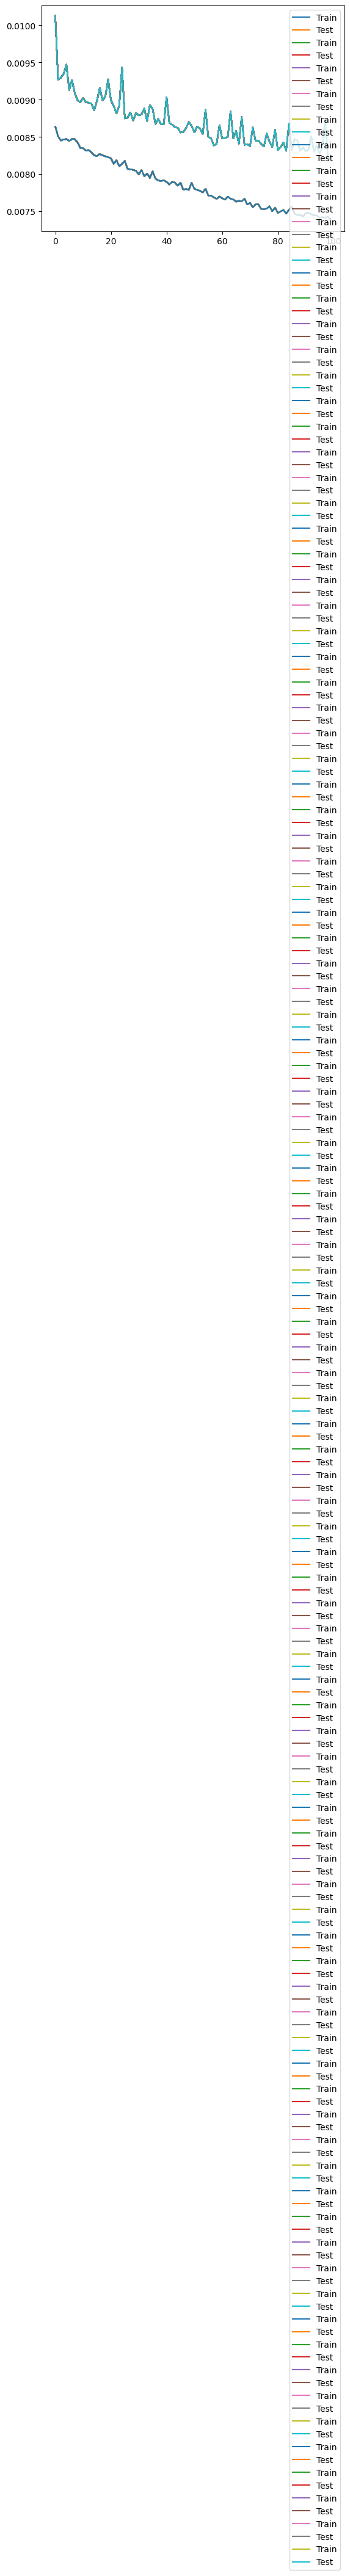

In [36]:
train_loss_list = []  
test_loss_list = []  

for i in range(epochs) :

    startTime = time.time()
    
    train_loss = train_epoch() #train one epoch, get the average loss
    train_loss_list.append(train_loss)
    
    test_loss = test_epoch() # test with test set
    test_loss_list.append(test_loss)
    
    epoch_time = time.time() - startTime
    
    writeString = "epoch " + str(i) + " train loss : " + str(train_loss) + " test loss : " + str(test_loss) + " epoch time : " + str(epoch_time) + "\n"
    
    # plot train/test loss graph
    plt.plot(train_loss_list, label="Train")
    plt.plot(test_loss_list, label="Test")
    plt.legend()

    if(save_results): # save all outputs to the save folder

        # write the text output to file
        with open(output_folder + "prints.txt","a") as file: 
            file.write(writeString)

        # update the loss graph
        plt.savefig(output_folder + "loss.png")
        plt.close()

        # save input/output as image file
        if(i%50==0):
            test_samples = next(iter(test_loader))
            loss , test_output = test_batch(test_samples)
            utils.plotPCbatch(test_samples, test_output, show=False, save=True, name = (output_folder  + "epoch_" + str(i)))

    else : # display all outputs
        
        test_samples = next(iter(test_loader))
        loss , test_output = test_batch(test_samples)

        if show_plots_during_training:
            utils.plotPCbatch(test_samples,test_output)

        print(writeString)

        if show_plots_during_training:
            plt.show()

# plot train/test loss graph
plt.plot(train_loss_list)

        


Original Point Cloud


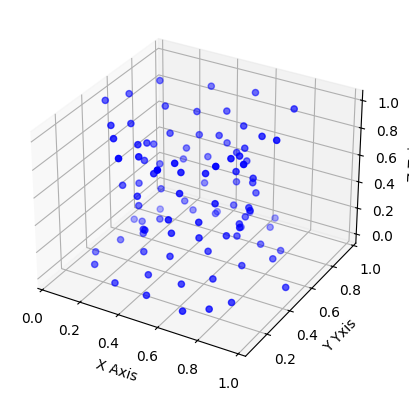

Reconstructed Point Cloud


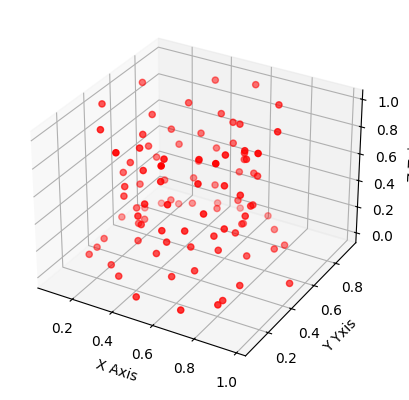

In [40]:
# make reconstruction of a single point cloud
test_samples = next(iter(test_loader))
loss , test_output = test_batch(test_samples)

#utils.plotPCbatch(test_samples,test_output)

print("Original Point Cloud")
visualize_pointcloud(test_samples[0])

print("Reconstructed Point Cloud")
visualize_pointcloud(test_output[0], color='r')
